# Imports

In [1]:
#no warnings about floating precision
import warnings
warnings.filterwarnings('ignore')

In [2]:
# LIMIT GPU MEMORY TAKEN UP BY THE NOTEBOOK
# you can specify the fraction of the AVAILABLE GPU memory that will be
# pre-allocated (jax default is .9)

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

#use another GPU if the default one is occupied
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
import jax
import jax.numpy as np

from jax.random import split, PRNGKey
from jax import lax

jax.config.update('jax_debug_nans', True)

### NOTE: f32 gives > 3x speedup wrt f64
#config.update('jax_enable_x64', True)

#use this line to set the device to be used for the computations
#print(jax.devices())
#DOES NOT RECOGNIZE THE OPTION NAME FTM
#jax.config.update('jax_default_device', jax.devices()[1])

import equinox as eqx

import haiku as hk

from functools import partial

In [4]:
from jax_md import space

In [5]:
import jax_morph

from jax_morph.visualization import draw_circles_ctype, draw_circles_chem, draw_circles_divrate

from jax_morph.datastructures import CellState, SpaceFunc
from jax_morph.simulation import simulation, sim_trajectory

from jax_morph.cell_division import S_cell_division
from jax_morph.cell_growth import S_grow_cells

from chem_twotypes.mechanical import S_mechmin_twotypes
from chem_twotypes.secdiff import S_ss_chemfield, sec_nn
from chem_twotypes.divrates import S_set_divrate, div_nn

from chem_twotypes.initial_states import init_state_grow

In [6]:
import matplotlib.pyplot as plt

from tqdm import tqdm

# Set Parameters

In [7]:
ParamsDict = dict

In [8]:
# Define parameters -- blue particles are type 1, orange are type 2
# keep jax type casting to place vars in gpu memory

# Number of chemical signals
n_chem = 2
n_celltype = 2

#-------------------------------------------------------------------------------
### NEW CLEAN VERSION

#rows are ctypes, cols are chemicals
#1 if ct secretes chem, 0 otw
#needs to be array for indexing

ctype_sec_chem = np.identity(n_chem, dtype=np.int16) #each ct secretes one chem
#ctype_sec_chem = np.ones((n_celltype,n_chem), dtype=np.int16) #every ct secretes everything
#ctype_sec_chem = np.hstack([np.identity(2)]*1)


### CELL DIMENSIONS

#change constants in divrate calculation if cellRad != .5 
# always use python scalars
cellRad = .5
cellRadBirth = float(cellRad / np.sqrt(2))


### DIFFUSION

#possibly different diffusion and degradation for each chemical
diffCoeff = np.ones(n_chem) #np.linspace(1.,n_chem/2+2,n_chem) # #np.array([1.,3.])
degRate = np.ones(n_chem) #np.array([1.,1.])

#diffusion cutoff
r_cutoffDiff = 5.*cellRad
r_onsetDiff = r_cutoffDiff - .5


### SECRETION

# sec rate that gives concentration 1 at source at SS
sec_max_unitary = 2*np.sqrt(diffCoeff*degRate)

sec_max = sec_max_unitary*np.ones((n_chem,), dtype=np.float32)
#sec_max = sec_max.at[0].set(20.)
#sec_max = sec_max.at[1].set(2.)


sec_gamma = .5* np.ones((n_chem,n_chem), dtype=np.float32) #was 0.01
sec_k = 1.*np.ones((n_chem,n_chem), dtype=np.float32) 


# # DIVISION

div_gamma = 2.*np.ones(n_chem, dtype=np.float32)
div_k = 1.*np.ones(n_chem, dtype=np.float32)
# div_k = div_k.at[0].set(3.)


# MORSE POTENTIAL
# always use python scalars
alpha = 3.
eps_TwoTwo = 3. #orange
eps_OneOne = 3. #blue
eps_OneTwo = 3. 

#morse cutoff
r_cutoff = 4.*cellRad
r_onset = r_cutoff - .2


# number of gradient descent steps for potential minimization
mech_relaxation_steps = 50


# Initialization and number of added cells. 
ncells_init = 10 #number of cells in the initial cluster
n_ones_init = 5 #number of type-1 cell in the initail cluster
ncells_add = 100
#ncells_tot =  np.int16(ncells_init+ncells_add)# final number of cells

assert ncells_init > n_ones_init

In [9]:
#equinox automatically treats as static all non-array values
#cast floats/ints into arrays if the parameter needs a gradient

def _maybe_array(name, value, train_params):
    if train_params[name]:
        return np.array(value)
    else:
        return value

In [10]:
train_params = {
    'n_chem': False,
    #'secreted_by_ctypes': False,
    'ctype_sec_chem': False,
    
    'sec_max': False,
    'sec_gamma': False,
    'sec_k' : False,
    
    'div_gamma' : False,
    'div_k' : False,
    
    'cellRad' : False,
    'cellRadBirth' : False,
    
    'diffCoeff' : False,
    'degRate' : False,
    'r_onsetDiff' : False,
    'r_cutoffDiff' : False,
    
    'alpha': False, 
    'eps_TwoTwo': False, 
    'eps_OneOne' : False,
    'eps_OneTwo' : False,
    'r_onset' : False,
    'r_cutoff' : False,
    'mech_relaxation_steps' : False,
    
    'ncells_init' : False,
    'n_ones_init': False, 
    #'ncells_tot': ncells_tot,
    'ncells_add': False,
}

In [11]:
params = {
    'n_chem': n_chem,
    #'secreted_by_ctypes': sec_by_ctypes,
    'ctype_sec_chem': ctype_sec_chem,
    
    'sec_max': sec_max,
    'sec_gamma': sec_gamma,
    'sec_k' : sec_k,
    
    'div_gamma' : div_gamma,
    'div_k' : div_k,
    
    'cellRad' : cellRad,
    'cellRadBirth' : cellRadBirth,
    
    'diffCoeff' : diffCoeff,
    'degRate' : degRate,
    'r_onsetDiff' : r_onsetDiff,
    'r_cutoffDiff' : r_cutoffDiff,
    
    'alpha': _maybe_array('alpha', alpha, train_params), 
    'eps_TwoTwo': _maybe_array('eps_TwoTwo', eps_TwoTwo, train_params), 
    'eps_OneOne' : _maybe_array('eps_OneOne', eps_OneOne, train_params),
    'eps_OneTwo' : _maybe_array('eps_OneTwo', eps_OneTwo, train_params),
    'r_onset' : r_onset,
    'r_cutoff' : r_cutoff,
    'mech_relaxation_steps' : mech_relaxation_steps,
    
    'ncells_init' : ncells_init,
    'n_ones_init': n_ones_init, 
    #'ncells_tot': ncells_tot,
    'ncells_add': ncells_add,
}



p, hp = eqx.partition(params, train_params)

# Simulation

In [12]:
key = PRNGKey(0)

## Generate initial state

In [13]:
# build initial state and space handling functions

fspace = SpaceFunc(*space.free())

key, init_key = split(key)

# generate initial state by growing from single cell
istate = init_state_grow(init_key, params, fspace)

## Generate init-apply functions

In [103]:
# init division nn
DIV_HIDDEN = 3

div_init, div_nn_apply = div_nn(params,train_params,DIV_HIDDEN,train=True)

params, train_params = div_init(istate, key)

In [104]:
#init secretion nn
SEC_HIDDEN = 5

sec_init, sec_nn_apply = sec_nn(params,train_params,SEC_HIDDEN,train=False)

params, train_params = sec_init(istate, key)

In [105]:
# functions in this list will be executed in the given order
# at each simulation step

fstep = [
    S_cell_division,
    partial(S_grow_cells, grate=.05),
    S_mechmin_twotypes,
    partial(S_ss_chemfield, sec_fn=sec_nn_apply),
    partial(S_set_divrate, divrate_fn=eqx.filter_jit(div_nn_apply))
]


sim_init, sim_step = simulation(fstep, params, fspace)

# Optimization

In [106]:
from jax import vmap, value_and_grad

import optax
from optax import adam, sgd

from jax_morph.losses import reinforce_loss, avg_loss, simple_loss
from jax_morph.state_metrics import diff_n_ctypes

## Optimization loop

In [107]:
EPOCHS = 30
EPISODES_PER_UPDATE = 128 #32

LEARNING_RATE = .05

p, hp = eqx.partition(params, train_params)

rloss = partial(reinforce_loss, metric_fn=partial(diff_n_ctypes, relative=True))
sloss = partial(simple_loss, metric_fn=partial(diff_n_ctypes, relative=True))



# init optimizer
optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(p)


#--------------------------------------------
#store loss at initial params and calc grad 

key, *batch_subkeys = split(key, EPISODES_PER_UPDATE+1)
batch_subkeys = np.array(batch_subkeys)


ll, grads = value_and_grad(avg_loss)(p, hp, rloss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)

l = avg_loss(p, hp, sloss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)

#store initial params and loss
loss_t = [float(l)]
#params_t = [p]
#rloss_t = [float(ll)]


#--------------------------------------------


for t in tqdm(range(EPOCHS), total=EPOCHS):
    
    #generate batch of random keys
    key, *batch_subkeys = split(key, EPISODES_PER_UPDATE+1)
    batch_subkeys = np.array(batch_subkeys)
    
    # sgd step
    updates, opt_state = optimizer.update(grads, opt_state, p)

    p = eqx.apply_updates(p, updates)
    
    # surrogate loss and grads
    ll, grads = value_and_grad(avg_loss)(p, hp, rloss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)
    
    #estimate actual avg loss
    l = avg_loss(p, hp, sloss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)
    
    #store
    loss_t.append(float(l))
    #rloss_t.append(float(ll))
    #params_t.append(p)
    

100%|████████████████████████████████████████████████| 30/30 [02:19<00:00,  4.66s/it]


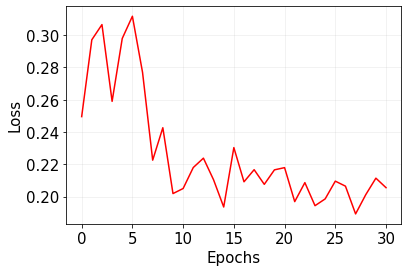

In [108]:
#plt.hlines(AVG_EQ_PARAMS, 0, EPOCHS, colors='k', linestyles='--')
#plt.axhspan(ymin=AVG_EQ_PARAMS-STD_EQ_PARAMS, ymax=AVG_EQ_PARAMS-STD_EQ_PARAMS, fc='k')

plt.plot(np.sqrt(np.array(loss_t)), 'r')
#plt.yscale('log')

plt.grid(alpha=.2)


plt.xlabel('Epochs')
plt.ylabel('Loss');

## Initial params

In [109]:
pp = params.copy()

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, pp, fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, ncells_add=100, key=subkey)


print(diff_n_ctypes(fstate, relative=True))
print(diff_n_ctypes(fstate))

0.14545454
16


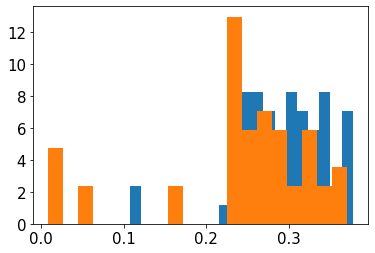

In [110]:
plt.hist(fstate.divrate[fstate.celltype==1].tolist(),20,density=True);
plt.hist(fstate.divrate[fstate.celltype==2].tolist(),20,density=True);

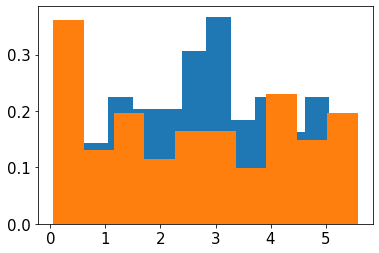

In [111]:
plt.hist(fstate.chemical[:,0].tolist(),density=True);
plt.hist(fstate.chemical[:,1].tolist(),density=True);

In [ ]:
plt.plot(fstate.chemical[:,0].tolist(), fstate.divrate.tolist(),'.', label='Chem 0')
plt.plot(fstate.chemical[:,1].tolist(), fstate.divrate.tolist(),'.', label='Chem 1')

plt.ylabel('divrate')
plt.xlabel('chemical conc.')

plt.legend();

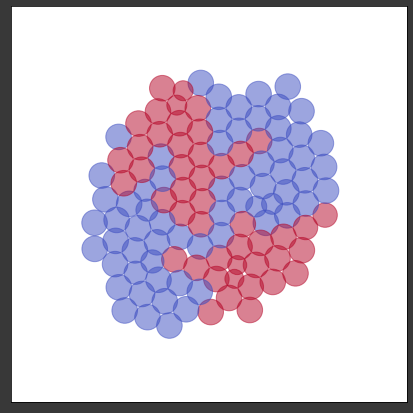

In [136]:
draw_circles_ctype(fstate);

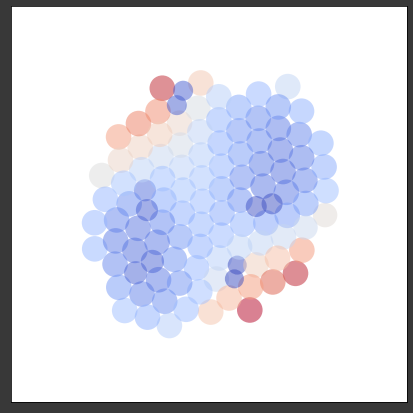

In [137]:
draw_circles_divrate(fstate);

## Trained params

In [113]:
# merge params dicts
all_params = eqx.combine(p, hp)

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, all_params, fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, ncells_add=300, key=subkey)



print(diff_n_ctypes(fstate, relative=True))
print(diff_n_ctypes(fstate))

0.3612903
112


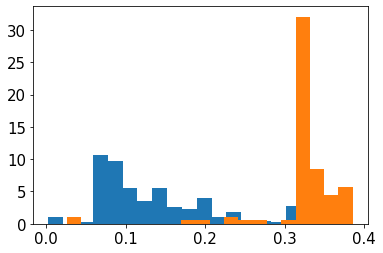

In [114]:
plt.hist(fstate.divrate[fstate.celltype==1].tolist(),20,density=True);
plt.hist(fstate.divrate[fstate.celltype==2].tolist(),20,density=True);

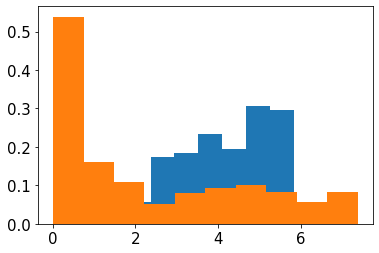

In [115]:
plt.hist(fstate.chemical[:,0].tolist(),density=True);
plt.hist(fstate.chemical[:,1].tolist(),density=True);

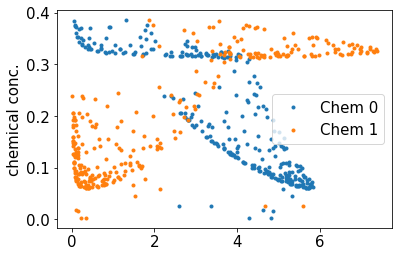

In [116]:
plt.plot(fstate.chemical[:,0].tolist(), fstate.divrate.tolist(),'.', label='Chem 0')
plt.plot(fstate.chemical[:,1].tolist(), fstate.divrate.tolist(),'.', label='Chem 1')

plt.ylabel('divrate')
plt.ylabel('chemical conc.')

plt.legend();

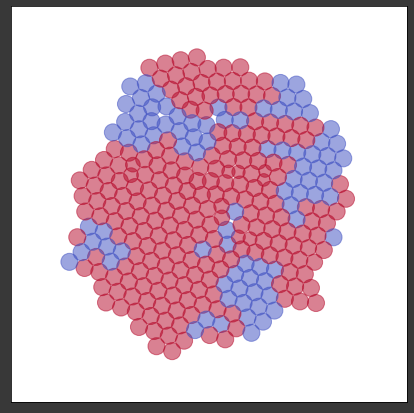

In [90]:
draw_circles_ctype(fstate);

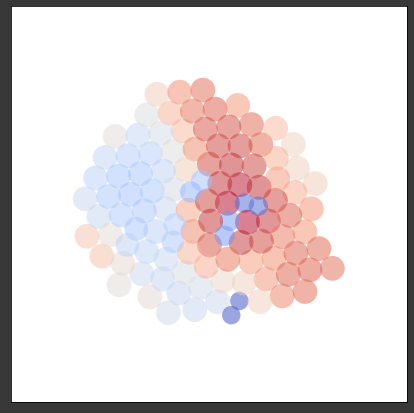

In [85]:
draw_circles_divrate(fstate);

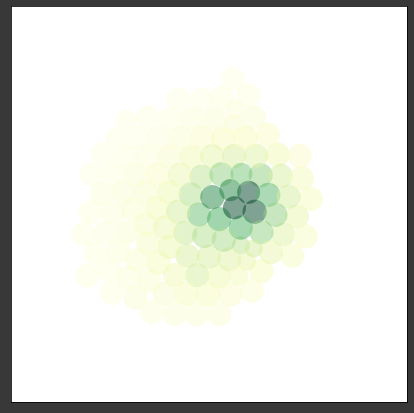

In [127]:
draw_circles_chem(fstate);

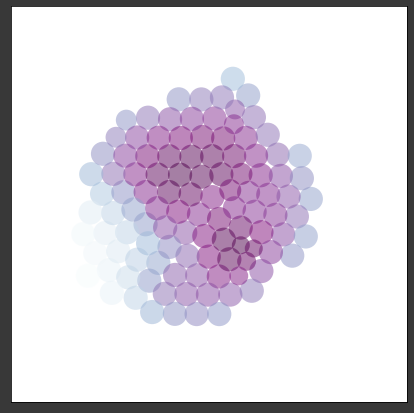

In [128]:
draw_circles_chem(fstate,1);

## More chem

In [73]:
pp = params.copy()

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, pp, fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, ncells_add=200, key=subkey)

0.9333334


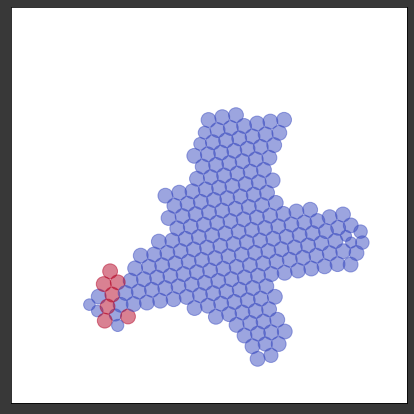

In [74]:
draw_circles_ctype(fstate);

print(diff_n_ctypes(fstate, relative=True))

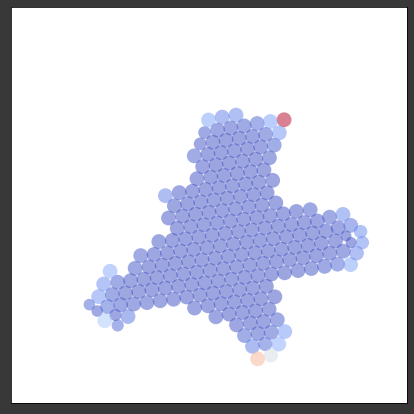

In [75]:
draw_circles_divrate(fstate);

## Different hidden sizes

In [30]:
#@eqx.filter_jit
def optimize(params,
             train_params,
             istate,
             key,
             EPOCHS = 10,
             EPISODES_PER_UPDATE = 128, #32
             LEARNING_RATE = .1,
             DIV_N = 3,
             SEC_N = 5,
             train_div=True,
             train_sec=False,
        ):

    key, subkey = split(key)
    div_init, div_nn_apply = div_nn(params,train_params,DIV_N,train=train_div)
    params, train_params = div_init(istate, subkey)

    #init secretion nn
    key, subkey = split(key)
    sec_init, sec_nn_apply = sec_nn(params,train_params,SEC_N,train=train_sec)
    params, train_params = sec_init(istate, subkey)
    
    fstep = [
        S_cell_division,
        partial(S_grow_cells, grate=.05),
        S_mechmin_twotypes,
        partial(S_ss_chemfield, sec_fn=sec_nn_apply),
        partial(S_set_divrate, divrate_fn=div_nn_apply)
    ]


    sim_init, sim_step = simulation(fstep, params, fspace)


    p, hp = eqx.partition(params, train_params)

    # init optimizer
    optimizer = optax.adam(LEARNING_RATE)
    opt_state = optimizer.init(p)


    #--------------------------------------------
    #store loss at initial params and calc grad 

    key, *batch_subkeys = split(key, EPISODES_PER_UPDATE+1)
    batch_subkeys = np.array(batch_subkeys)


    ll, grads = value_and_grad(avg_loss)(p, hp, reinforce_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)

    l = avg_loss(p, hp, simple_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)

    #store initial params and loss
    #params_t = [p]
    #loss_t = [float(l)]
    #rloss_t = [float(ll)]


    #--------------------------------------------

    loss_t = np.zeros(EPOCHS+1)
    loss_t = loss_t.at[0].set(l)

    for t in tqdm(np.arange(EPOCHS), total=EPOCHS):

        #generate batch of random keys
        key, *batch_subkeys = split(key, EPISODES_PER_UPDATE+1)
        batch_subkeys = np.array(batch_subkeys)

        # sgd step
        updates, opt_state = optimizer.update(grads, opt_state, p)

        p = eqx.apply_updates(p, updates)

        # surrogate loss and grads
        ll, grads = value_and_grad(avg_loss)(p, hp, reinforce_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)

        #estimate actual avg loss
        l = avg_loss(p, hp, simple_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)

        #store
        #loss_t.append(float(l))
        #rloss_t.append(float(ll))
        #params_t.append(p)
        loss_t = loss_t.at[t+1].set(l)
    
    return np.sqrt(loss_t), p

In [33]:
@eqx.filter_jit
def optimize(params,
             train_params,
             istate,
             key,
             EPOCHS = 10,
             EPISODES_PER_UPDATE = 128, #32
             LEARNING_RATE = .1,
             DIV_N = 3,
             SEC_N = 5,
             train_div=True,
             train_sec=False,
        ):

    key, subkey = split(key)
    div_init, div_nn_apply = div_nn(params,train_params,DIV_N,train=train_div)
    params, train_params = div_init(istate, subkey)

    #init secretion nn
    key, subkey = split(key)
    sec_init, sec_nn_apply = sec_nn(params,train_params,SEC_N,train=train_sec)
    params, train_params = sec_init(istate, subkey)
    
    fstep = [
        S_cell_division,
        partial(S_grow_cells, grate=.05),
        S_mechmin_twotypes,
        partial(S_ss_chemfield, sec_fn=sec_nn_apply),
        partial(S_set_divrate, divrate_fn=div_nn_apply)
    ]


    sim_init, sim_step = simulation(fstep, params, fspace)


    p, hp = eqx.partition(params, train_params)

    # init optimizer
    optimizer = optax.adam(LEARNING_RATE)
    opt_state = optimizer.init(p)


    #--------------------------------------------
    #store loss at initial params and calc grad 

    key, *batch_subkeys = split(key, EPISODES_PER_UPDATE+1)
    batch_subkeys = np.array(batch_subkeys)


    ll, grads = value_and_grad(avg_loss)(p, hp, reinforce_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)

    l = avg_loss(p, hp, simple_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)

    #store initial params and loss
    #params_t = [p]
    #loss_t = [float(l)]
    #rloss_t = [float(ll)]


    #--------------------------------------------

    loss_t = np.zeros(EPOCHS+1)
    loss_t = loss_t.at[0].set(l)

    for t in np.arange(EPOCHS):

        #generate batch of random keys
        key, *batch_subkeys = split(key, EPISODES_PER_UPDATE+1)
        batch_subkeys = np.array(batch_subkeys)

        # sgd step
        updates, opt_state = optimizer.update(grads, opt_state, p)

        p = eqx.apply_updates(p, updates)

        # surrogate loss and grads
        ll, grads = value_and_grad(avg_loss)(p, hp, reinforce_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)

        #estimate actual avg loss
        l = avg_loss(p, hp, simple_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)

        #store
        #loss_t.append(float(l))
        #rloss_t.append(float(ll))
        #params_t.append(p)
        loss_t = loss_t.at[t+1].set(l)
    
    return np.sqrt(loss_t), p

In [34]:
div_ns = [2,3]#,5,10]

loss_n = {}
pp_n = {}

for DIV_N in div_ns:
    
    print(f'Training with {DIV_N} neurons...')
    
    key, subkey = split(key)

    lt,pp = optimize(params, train_params, istate, subkey, 10, DIV_N=DIV_N, SEC_N=7)
    
    loss_n[DIV_N] = lt.tolist()
    pp_n[DIV_N] = pp

Training with 2 neurons...


UnexpectedTracerError: An UnexpectedTracerError was raised while inside a Haiku transformed function (see error above).
Hint: are you using a JAX transform or JAX control-flow function (jax.vmap/jax.scan/...) inside a Haiku transform? You might want to use the Haiku version of the transform instead (hk.vmap/hk.scan/...).
See https://dm-haiku.readthedocs.io/en/latest/notebooks/transforms.html on why you can't use JAX transforms inside a Haiku module.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.UnexpectedTracerError

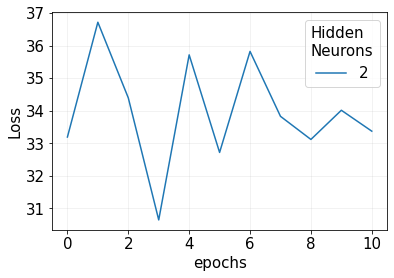

In [32]:
for n in loss_n:
    plt.plot(loss_n[n], label=str(n))
    
    
plt.xlabel('epochs')
plt.ylabel('Loss')

    
plt.grid(alpha=.2)
plt.legend(title='Hidden\nNeurons');

In [21]:
p, hp = eqx.partition(params, train_params)


for n in pp_n:
    
    key, subkey = split(key)

    div_init, div_nn = div_nn_chem(params,train_params,n)

    params, train_params = div_init(istate, subkey)
    
    ppp, hpp = eqx.partition(params, train_params)
    
    key, *subkeys = split(key, 301)
    subkeys = np.array(subkeys)

    lss = simple_loss(ppp, hpp, fstep, fspace, istate, subkeys)

    plt.hist(np.sqrt(lss).tolist(), alpha=.3, label=str(n), density=True)
    
    
plt.legend();

NameError: name 'div_nn_chem' is not defined

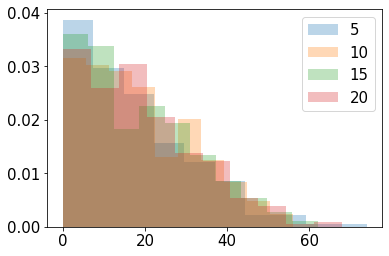

In [49]:
p, hp = eqx.partition(params, train_params)


for n in pp_n:
    
    key, *subkeys = split(key, 301)
    subkeys = np.array(subkeys)

    lss = simple_loss(pp_n[n], hp, fstep, fspace, istate, subkeys)

    plt.hist(np.sqrt(lss).tolist(), alpha=.3, label=str(n), density=True)
    
    
plt.legend();

In [37]:
fstate.divrate

DeviceArray([0.47893405, 0.479799  , 0.47960663, 0.47919053, 0.43481365,
             0.48003292, 0.47829497, 0.4793114 , 0.4798279 , 0.47927994,
             0.47924203, 0.33632067, 0.47972077, 0.47946215, 0.47810355,
             0.47902876, 0.4799136 , 0.47954038, 0.47965986, 0.4784856 ,
             0.47939584, 0.4793705 , 0.47854024, 0.47905976, 0.48427406,
             0.47975993, 0.47982445, 0.47851464, 0.4799242 , 0.47895494,
             0.47853887, 0.47889096, 0.4796374 , 0.4793157 , 0.47842255,
             0.47998303, 0.47937834, 0.4795779 , 0.47886267, 0.47880346,
             0.48004547, 0.479682  , 0.47809738, 0.48010644, 0.47996804,
             0.47845185, 0.47914505, 0.49336907, 0.49982172, 0.47830904,
             0.47827202, 0.47975034, 0.4797943 , 0.47976375, 0.47980496,
             0.48009828, 0.4781177 , 0.47936374, 0.47895813, 0.47847086,
             0.47961307, 0.47984284, 0.4793261 , 0.47989503, 0.4799767 ,
             0.47918433, 0.4796948 , 0.47891623, 0.